In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
# setup disply parameters
import pandas as pd
import numpy as np
from rich import print
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter

float_formatter = StrMethodFormatter("{x:0.03f}")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=(18, 6))  # set figure size

## Integrating with Genius

[Genius](http://ii.tudelft.nl/genius/) is a commonly used automated negotiation research platform implemented in Java. It was used to run [ANAC](http://web.tuat.ac.jp/~katfuji/ANAC2024/) and has hundreds of implemented negotiation strategy for the AOP and SAOP negotiation protocols. It supports other protocols but few existing negotiation strategies are available for any protocols other than AOP and SAOP.

NegMAS provides a bridge allowing you to run Genius agents and NegMAS negotiators. This bridge **does not** come bundled with NegMAS.

### Installing the bridge

After installing NegMAS, you can download and prepare the bridge by running the following command in your terminal:

```bash
negmas genius-setup
```

You can check that everything is OK by running:

```bash
java -jar $HOME/negmas/files/geniusbridge.jar --version
```

#### Direct Download

You can also just download the bridge [here](https://yasserfarouk.github.io/files/geniusbdidge.jar) and copy it to a folder `files` under `negmas` in your home directory. For Linx and macOS, you can just run:

```bash
curl https://yasserfarouk.github.io/files/geniusbridge.jar --create-dirs -o $HOME/negmas/files/geniusbridge.jar
```

For Windows, open a power-shell terminal and run:

```PowerShell
Invoke-WebRequest -Uri https://yasserfarouk.github.io/files/geniusbridge.jar -OutFile $HOME\negmas\files\geniusbridge.jar
```

### Running the bridge

Whenever you want to use a Genius agent from negmas, it is recommended (but not necessary) to explicitly run the bridge using:

```bash
java -jar $HOME/negmas/files/geniusbridge.jar
```

You should get something like:

```
received options:
Gateway 0.4.13 to python started at port 25337 listening to port 25337 [forcing timeout: 1800000ms]
```

### Running a negotiation from the command line

Firstly, let's get a negotiation scenario into your machine to use for this experiment. You can download an example domain [here](https://yasserfarouk.github.io/files/CameraB.zip), and unzip it to some place in your hard-disk to use later for the negotiation. Or just run the following command to download it to `negmas/scenarios/CameraB` under your home directory:

- On Linux and 
  ```bash
  curl https://yasserfarouk.github.io/files/CameraB.zip --create-dirs -o $HOME/negmas/scenarios/CameraB.zip
  unzip $HOME/negmas/scenarios/CameraB.zip -d $HOME/negmas/scenarios/
  rm $HOME/negmas/scenarios/CameraB.zip
  ```
- On Windows (You'll need an unzip utility like [7-Zip](https://www.7-zip.org/) installed for this script to work.)
  ```PowerShell  
  Invoke-WebRequest -Uri https://yasserfarouk.github.io/files/CameraB.zip -OutFile $HOME/negmas/scenarios/CameraB.zip
  7z x $HOME/negmas/scenarios/CameraB.zip -o$HOME\negmas\scenarios
  Remove-Item $HOME/negmas/scenarios/CameraB.zip
  ```

Now we are ready to try the bridge from the command line:

```bash
negotiate $HOME/negmas/scenarios/CameraB --no-plot -p sao -n AspirationNegotiator -n genius.BoulwareNegotiationParty --steps=100
```

You should get something like:

![negexample](negexample.jpg)

You can also visualize the negotiation using:

```bash
negotiate $HOME/negmas/scenarios/CameraB --plot -p sao -n AspirationNegotiator -n genius.BoulwareNegotiationParty --steps=100
```

![negplot](negplot.jpg)

### Running a negotiation in python

You can run a negotiation between that has some Genius negotiators in them in python almost as easily as running a negotiation between two native NegMAS negotiators. Here is an example using the scenario we just saved:

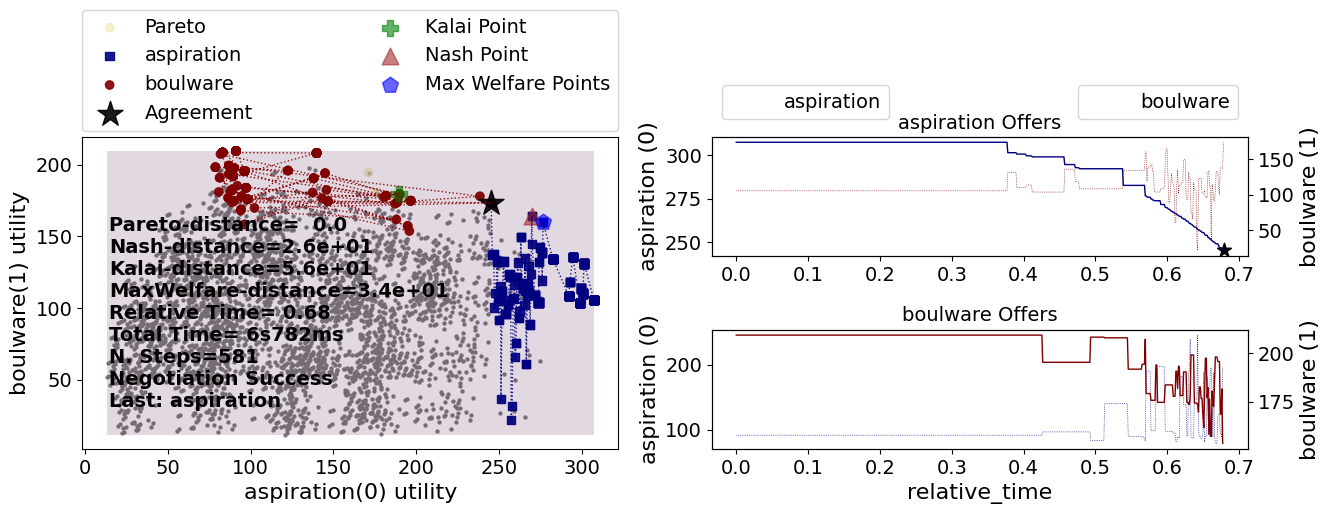

In [6]:
from pathlib import Path
from negmas.inout import Scenario
from negmas.sao.negotiators import AspirationNegotiator
from negmas.genius.gnegotiators import BoulwareNegotiationParty

scenario = Scenario.load(Path.home() / "negmas" / "scenarios" / "CameraB")
session = scenario.make_session(time_limit=10)
session.add(AspirationNegotiator(preferences=scenario.ufuns[0], name="aspiration"))
session.add(BoulwareNegotiationParty(preferences=scenario.ufuns[1], name="boulware"))
session.run()
session.plot()
plt.show()

As you can see, there is no difference between using a native NegMAS negotiator and a Genius Negotiator except in where you import it from. For NegMAS SAO negotiators, you use `negmas.sao.negotiators` and for genius negotiators you use `negmas.genius.gnegotiators`. Everything else is the same.

You can even run a negotiation between two Genius negotiators directly:

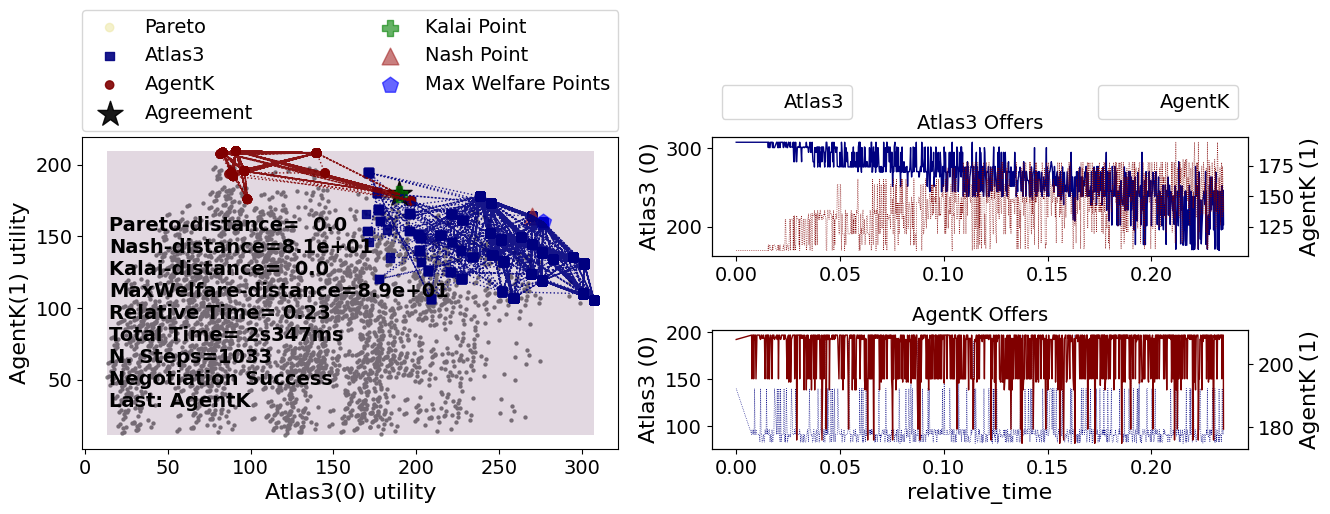

In [7]:
from negmas.genius.gnegotiators import Atlas3, AgentK

session = scenario.make_session(time_limit=10)
session.add(Atlas3(preferences=scenario.ufuns[0], name="Atlas3"))
session.add(AgentK(preferences=scenario.ufuns[1], name="AgentK"))
session.run()
session.plot()
plt.show()

### How does it work?

This integration is supported by the [GeniusNegotiator](https://negmas.readthedocs.io/en/latest/api/negmas.genius.GeniusNegotiator.html). This class, presents Genius agents as [SAONegotiator](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAONegotiator.html) objects to NegMAS. The most important difference between a `GeniusNegotiator` and a normal `SAONegotiator` from the user's point of view is the way they are constructed. A `GeniusNegotiator` has the following extra parameters in its `__init__()` function:

- java_class_name (str | None) – The java class name of the Geinus underlying agent
- domain_file_name (str | Path | None) – Optional domain file name (containing the negotiation issues or agenda)
- utility_file_name (str | Path | None) – Optional ufun file name (xml) from which a ufun will be loaded for the agent- 
- auto_load_java (bool) – Load the genius bridge if needed
- port (int) – The port to load the genius bridge to (or use if it is already loaded)
- genius_bridge_path (str | None) – The path to the genius bridge

Inside `genius.gnegotiators` we simply create classes for all Genius agents like this:

```python
class Atlas3(GeniusNegotiator):
    def __init__(self, **kwargs):
        kwargs["java_class_name"] = "agents.anac.y2015.Atlas3.Atlas3"
        super().__init__(**kwargs)
```

If you missed any Genius agent, you can add it by just passing the `java_class_name` parameter during construction in the same way.

Let's try to run the same negotiation above without using `gnegotiators` at all:


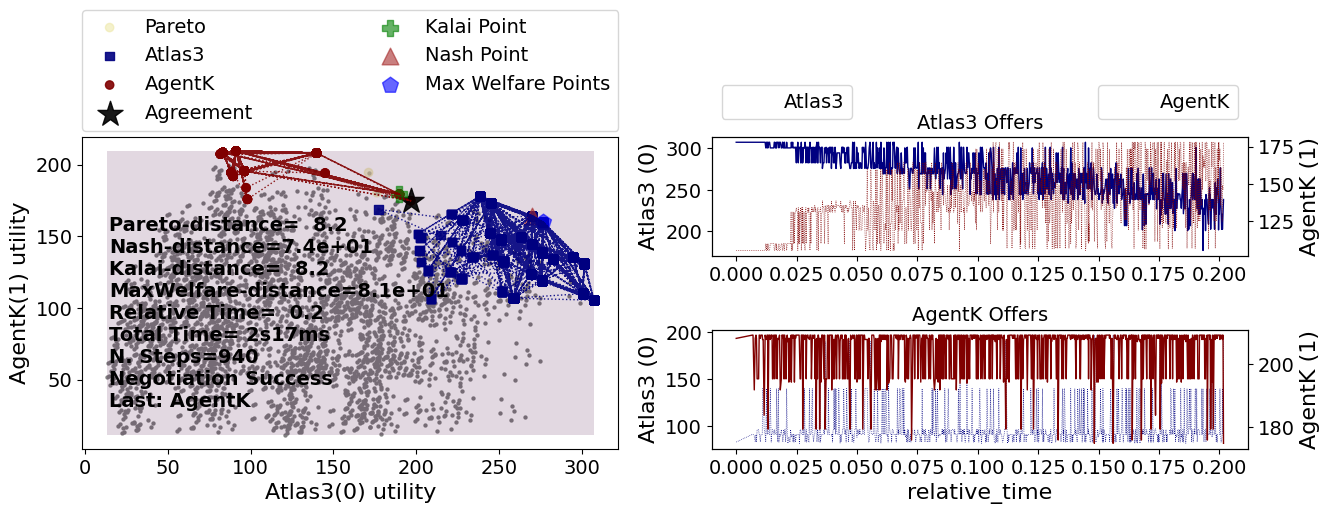

In [9]:
from negmas.genius import GeniusNegotiator

session = scenario.make_session(time_limit=10)
session.add(
    GeniusNegotiator(
        java_class_name="agents.anac.y2015.Atlas3.Atlas3",
        preferences=scenario.ufuns[0],
        name="Atlas3",
    )
)
session.add(
    GeniusNegotiator(
        java_class_name="agents.anac.y2010.AgentK.Agent_K",
        preferences=scenario.ufuns[1],
        name="AgentK",
    )
)
session.run()
session.plot()
plt.show()